In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
raw_mail_data = pd.read_csv("/content/data.csv")

In [3]:
mail_data = raw_mail_data.where((pd.notnull(raw_mail_data)), '')

In [4]:
mail_data.head(5)

,Category,Content
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a..."
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\nthis deal is to ...


In [5]:
mail_data.shape

(5171, 2)

In [6]:
mail_data['Category'].value_counts()

ham     3672
spam    1499
Name: Category, dtype: int64

In [7]:
#### Encoding Category Column
#### Spam mail label as 1 and Ham mail label as 0
mail_data.loc[mail_data['Category'] == 'spam', 'Category_Label'] = 1
mail_data.loc[mail_data['Category'] == 'ham', 'Category_Label'] = 0

In [8]:
mail_data.head(5)

,Category,Content,Category_Label
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0.0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0.0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0.0
3,spam,"Subject: photoshop , windows , office . cheap ...",1.0
4,ham,Subject: re : indian springs\nthis deal is to ...,0.0


In [9]:
X = mail_data['Content'].values
Y = mail_data['Category_Label'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

In [11]:
print("Original data size:", X.shape[0])
print("Train data size:", X_train.shape[0])
print("Test data size:", X_test.shape[0])

Original data size: 5171
Train data size: 4136
Test data size: 1035


In [12]:
##### Text feature extraction using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(min_df=1, lowercase=True, stop_words='english')

In [13]:
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [14]:
##### Model selection and hyper-parameter tuning using GridSearchCV
models = {
    "svm_linear": {
        "instance": SVC(probability=True, gamma="auto", kernel="linear"),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }
    },
    "logistic_regression": {
        "instance": LogisticRegression(max_iter=500),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }
    },
}

In [16]:
scores = []
best_estimators = {}

for model_name, config in models.items():
    print("Training", model_name)

    classifier = GridSearchCV(
        estimator=config["instance"],
        param_grid=config["params"],
        cv=5,
        scoring="accuracy"
    )

    classifier.fit(X_train_features, y_train)

    scores.append({
        "model" : model_name,
        "train_score" : classifier.best_score_,
        "test_score" : classifier.best_estimator_.score(X_test_features, y_test),
        "params" : classifier.best_params_
    })

    best_estimators[model_name] = classifier.best_estimator_

Training svm_linear
Training logistic_regression


In [17]:
result = pd.DataFrame(scores, columns=["model", "train_score", "test_score", "params"])
result.head()

,model,train_score,test_score,params
0,svm_linear,0.987668,0.997101,{'C': 10}
1,logistic_regression,0.989361,0.995169,{'C': 1000}


In [18]:
#Both SVM and Logistic Regression model shows good average score. Since logistic regression works better with binary classification we will work with that.
model = best_estimators['logistic_regression']

In [19]:
print("ACCURACY SCORE")
print("Training Set:", accuracy_score(y_true=y_train, y_pred=model.predict(X_train_features)) * 100, "%")
print("Testing Set:", accuracy_score(y_true=y_test, y_pred=model.predict(X_test_features)) * 100, "%")

ACCURACY SCORE
Training Set: 100.0 %
Testing Set: 99.51690821256038 %


In [20]:
print("CLASSIFICATION REPORT")
print(classification_report(y_true=y_test, y_pred=model.predict(X_test_features)))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       731
         1.0       0.99      1.00      0.99       304

    accuracy                           1.00      1035
   macro avg       0.99      1.00      0.99      1035
weighted avg       1.00      1.00      1.00      1035



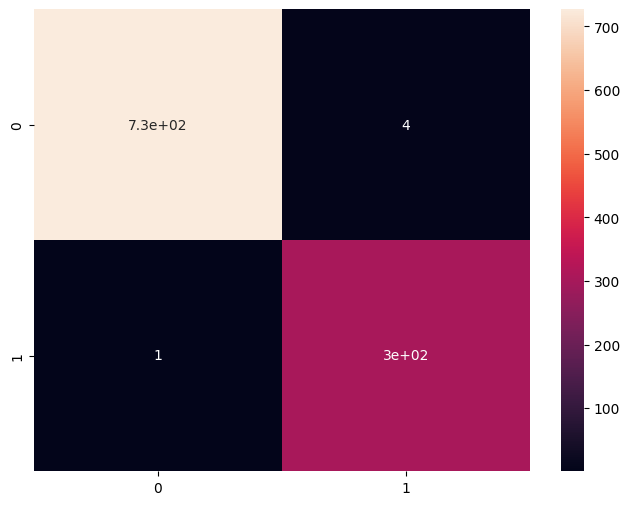

In [21]:
matrix = confusion_matrix(y_true=y_test, y_pred=model.predict(X_test_features))

plt.figure(figsize=(8,6))
plt.xlabel("PREDICTED")
plt.ylabel("TRUTH")
sns.heatmap(matrix, annot=True)
plt.show()

In [22]:
predictions = pd.DataFrame()

predictions["Content"] = X_test

predictions["Real Category"] = y_test
predictions["Predicted Category"] = model.predict(X_test_features)

predictions.loc[predictions['Real Category'] == 0, 'Real Category'] = 'Ham'
predictions.loc[predictions['Real Category'] == 1, 'Real Category'] = 'Spam'

predictions.loc[predictions['Predicted Category'] == 0, 'Predicted Category'] = 'Ham'
predictions.loc[predictions['Predicted Category'] == 1, 'Predicted Category'] = 'Spam'

predictions.to_csv("/content/test_prediction_result.csv", index=False)

predictions.head(10)

,Content,Real Category,Predicted Category
0,"Subject: what the heck\ndaren ,\nnow what ? i ...",Ham,Ham
1,Subject: hilcorp old ocean volume\naccording t...,Ham,Ham
2,"Subject: jurirne get latest softwares , 99 % s...",Spam,Spam
3,Subject: sitara patch\na patch is being releas...,Ham,Ham
4,Subject: archived great shots of california li...,Spam,Spam
5,Subject: this is hillarious !\ntake a minute a...,Ham,Ham
6,Subject: devon\ni understand you guys want to ...,Ham,Ham
7,Subject: feb noms\n- - - - - - - - - - - - - -...,Ham,Ham
8,Subject: please read - important information f...,Ham,Ham
9,Subject: \nreceived : from 182 . 152 . 35 . 18...,Spam,Spam
